In [1]:
# the usual imports
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# imports from the package
import particles
from particles import state_space_models as ssm
from particles import distributions as dists

ModuleNotFoundError: No module named 'seaborn'

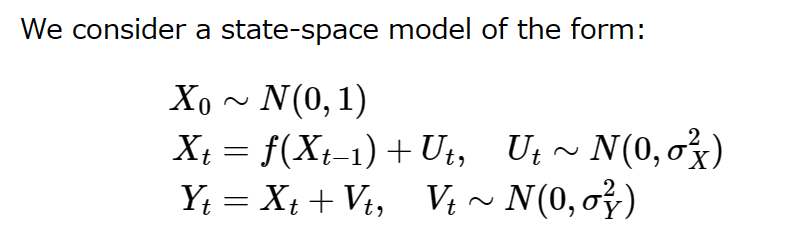

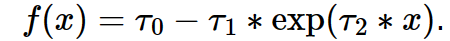

このモデルはtheta logistic modelと呼ばれ、個体群生態学（population ecology）で扱われるもの。  
$X_t$はある「種」（例えば洞窟内のコウモリ）の人口サイズの対数に相当する。

上図は$f(x)=x+\tau_0-\tau_1*\exp(\tau_2 x)$。
- $\tau_1=\tau_2=0$ならば、人口は$\tau_0$のレートで指数関数的に増加する
- $-\tau_1*\exp(\tau_2 x)$の項は$X_t$がある閾値に達すると成長を抑制する。（環境収容力：carrying capacity、ある環境に継続的に存在できる生物の最大量）
- $\tau_1 >0$であれば、人口サイズは安定な平衡状態$(\tau_0/\tau_1)^{1/\tau_2}$
- $\tau_2=1$はリッカーモデルとして知られる。
- 特定のパラメータに対しては$\{X_t\}$は強い非線形性を示し、カオス的なふるまいを示す。

In [4]:
class ThetaLogistic(ssm.StateSpaceModel):
    """ Theta-Logistic state-space model (used in Ecology).
    """
    default_params = {'tau0':.15, 'tau1':.12, 'tau2':.1, 'sigmaX': 0.47, 'sigmaY': 0.39}

    def PX0(self):  # Distribution of X_0
        return dists.Normal()

    def f(self, x):
        return (x + self.tau0 - self.tau1 * np.exp(self.tau2 * x))

    def PX(self, t, xp):  #  Distribution of X_t given X_{t-1} = xp (p=past)
        return dists.Normal(loc=self.f(xp), scale=self.sigmaX)

    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x, and X_{t-1}=xp
        return dists.Normal(loc=x, scale=self.sigmaY)

Text(0, 0.5, 'data')

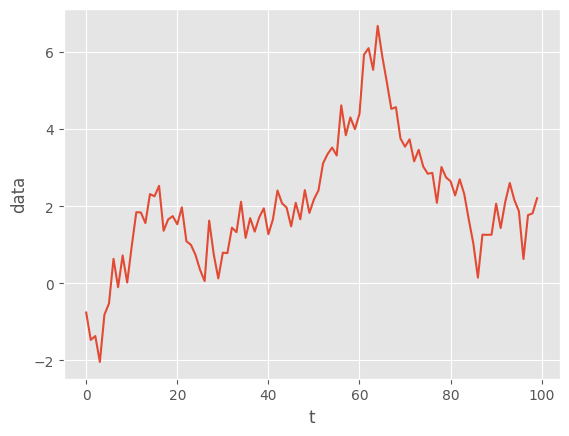

In [5]:
my_ssm = ThetaLogistic()  # use default values for all parameters
x, y = my_ssm.simulate(100)

plt.style.use('ggplot')
plt.plot(y)
plt.xlabel('t')
plt.ylabel('data')

In [9]:
fk_boot = ssm.Bootstrap(ssm=my_ssm, data=y)
my_alg = particles.SMC(fk=fk_boot, N=100)
my_alg.run()

ssm.BoostrapはFeynmanKacのサブクラス。
Feynman-KacモデルはSMCアルゴリズムのレシピを与える：
1. 先祖粒子$X_{t-1}^n, (n=1,...,N)$が与えられたとき、次の粒子$X_t^n$をどうサンプリングすればよいか
2. 粒子$X_t^n$をどう重み付け（reweight）すべきか

Boostrap filterはその特殊なレシピ：
1. X_t^nを状態遷移モデルに基づいてサンプリングする。今回ならば$N(f(x_{t-1}),\sigma_X^2)$に基づいてサンプリングする。
2. 粒子をモデルの尤度に基づいて重みづけする。今回ならば、観測$y_t$を得たうえで、モデル$N(x_t,\sigma_Y^2)$の尤度を見る？

Boostrap filter以外にもguided filterなどを実行できる。guided filterでは、ユーザが指定した提案カーネルに基づいて粒子がシミュレートされる。その場合はproposal, proposal0メソッドを追加する。

In [10]:
class ThetaLogistic_with_prop(ThetaLogistic):
    def proposal0(self, data):
        return self.PX0()
    def proposal(self, t, xp, data):
        prec_prior = 1. / self.sigmaX**2
        prec_lik = 1. / self.sigmaY**2
        var = 1. / (prec_prior + prec_lik)
        mu = var * (prec_prior * self.f(xp) + prec_lik * data[t])
        return dists.Normal(loc=mu, scale=np.sqrt(var))

my_better_ssm = ThetaLogistic_with_prop()

In [11]:
fk_guided = ssm.GuidedPF(ssm=my_better_ssm, data=y)

In [12]:
alg = particles.SMC(fk=fk_guided, N=100, qmc=False, resampling='systematic', ESSrmin=0.5,
                    store_history=False, verbose=False, collect=None)

- fk: FeynmanKacオブジェクト
- N: 粒子数
- qmc: QMC（準モンテカルロ法）を用いるかどうか
- resampling: リサンプリング法（"multinomial", "residual", "stratified", "systematic", "ssp"が選択可能）
- ESSrmin: ESS/Nがこの閾値を下回るとリサンプリングを行う。ESS:有効粒子数のようなもの
- verpose: 進捗の出力

In [22]:
# next(alg) # processes data-point y_0
# next(alg)  # processes data-point y_1
# for _ in range(8):
#     next(alg)  # processes data-points y_3 to y_9
alg.run()  # would process all the remaining data-points

algは次のアトリビュートを持つ：
- alg.t: 次のイタレーションのindex
- alg.X: N個の現在の粒子$X_t^n$。(N,)か(N,d)次元のnumpy array
- alg.W: 正規化された重み$W_t^n$。（N,）次元のnumpy array
- alg.Xp: N個の一時点前の粒子$X_{t-1}^n$
- alg.A: N個の先祖粒子：A[3]=12はX_t^3の親がX_{t-1}^12であることを示す
- alg.summaries: イタレーションごとの様々なサマリ

(array([2.52708580e-03, 5.63193999e-02, 1.37304812e-02, 6.49672618e-03,
        4.67024042e-02, 8.87571878e-02, 7.41450538e-02, 3.94909606e-02,
        1.28648026e-01, 1.27315917e-01, 9.44518173e-02, 8.01092388e-02,
        8.90967754e-02, 6.26613054e-02, 5.27146372e-02, 2.74586939e-02,
        8.00487353e-03, 1.31745105e-03, 0.00000000e+00, 5.19650618e-05]),
 array([-2.0144786 , -1.9284453 , -1.84241201, -1.75637871, -1.67034542,
        -1.58431212, -1.49827883, -1.41224554, -1.32621224, -1.24017895,
        -1.15414565, -1.06811236, -0.98207906, -0.89604577, -0.81001248,
        -0.72397918, -0.63794589, -0.55191259, -0.4658793 , -0.37984601,
        -0.29381271]),
 <BarContainer object of 20 artists>)

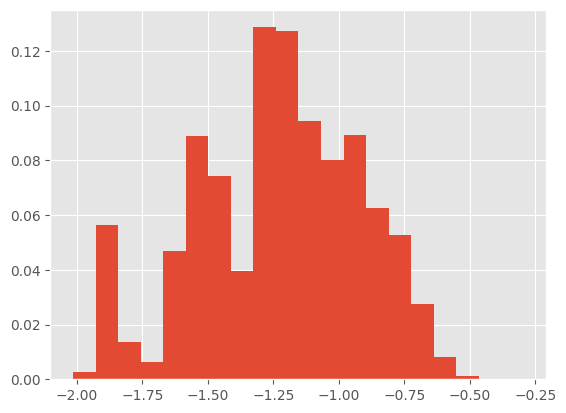

In [23]:
plt.hist(alg.X, 20, weights=alg.W)

Text(0, 0.5, 'ESS')

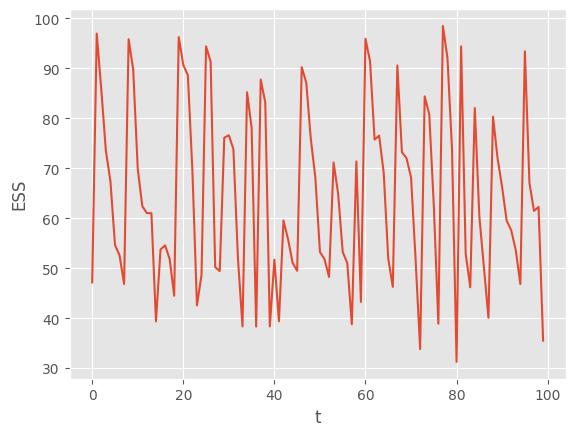

In [24]:
plt.plot(alg.summaries.ESSs)
plt.xlabel('t')
plt.ylabel('ESS')

Text(0, 0.5, 'log-likelihood')

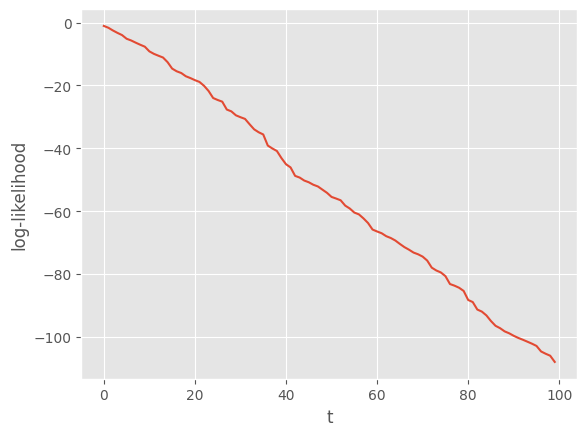

In [25]:
plt.plot(alg.summaries.logLts)
plt.xlabel('t')
plt.ylabel('log-likelihood')

SMCに以下の引数を追加することで、multiSMCを実行することができる。  
- nruns: runの数
- nprocs: nprocs>0ならば、使用するCPUコア数。nprocs<0ならば使用しないCPUコア数。nprocs=は全てのコアを使用する
- out_func: それぞれの粒子フィルタに対して適用される関数（後述）

In [26]:
outf = lambda pf: pf.logLt
results = particles.multiSMC(fk={'boot':fk_boot, 'guid':fk_guided},
                             nruns=20, nprocs=1, out_func=outf)

先のコードは40の1コアで粒子アルゴリズムを実行する（20のbootstrap filter, 20のguided filter）。出力resultは40の辞書のリスト。それぞれの辞書は次の（key, value）の組を持つ。  
- "model": "boot" or "guid" (bootstrap, guidedのどちらが実行されたか)
- "run": 実行番号（0~19）
- "output": outf(pf)の結果（pf: 実行されたSMCオブジェクト）（outf=Noneの場合は、SMCオブジェクトが返される）

outfが用意されているのは、特定の場合にSMCオブジェクトが大きなメモリを使用するから（特にstore_history=Trueとした場合）。そのため、オブジェクトそのものを完全に保存するのではなく、特定の興味のある結果のみを保存することができる。ここでは各粒子フィルタの対数尤度の推定値のみを出力させている。

<Axes: >

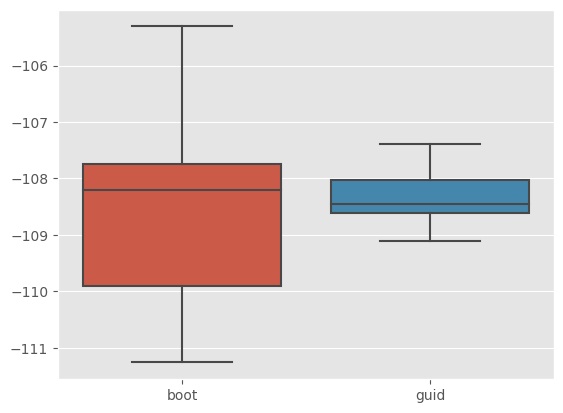

In [27]:
sb.boxplot(x=[r['fk'] for r in results],  y=[r['output'] for r in results])

alg.summaries (alg: SMCオブジェクト)は各イタレーション時の諸量（ESSや対数尤度の推定値）を含む。ここに他の量を計算させることも可能である。
- モーメント：各時刻tに辞書（キー："mean", "var"）を用意して、component-wiseな重み付き平均と分散を保存できる
- オンライン平滑化推定値：　単純にはO(N^2)の計算量。詳しくはcollectorsモジュールを確認。

collectパラメータにCollectorオブジェクトのリストを与えることで、以上が実現できる。


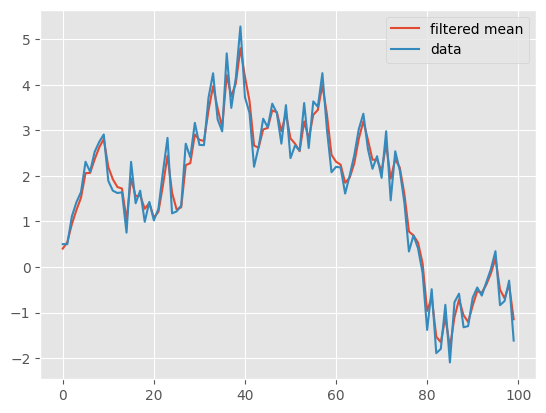

In [29]:
from particles.collectors import Moments

alg_with_mom = particles.SMC(fk=fk_guided, N=100, collect=[Moments()])
alg_with_mom.run()

plt.plot([m['mean'] for m in alg_with_mom.summaries.moments],
         label='filtered mean')
plt.plot(y, label='data')
plt.legend()

オフライン平滑化は、最後の時刻Tにおいて、すべてのデータ$Y_{0:T}$を用いて、すべての状態の分布$X_{0:T}$を推定するタスク。

オフライン平滑化を実行したい場合は、粒子フィルタを実行しその履歴を保存しておく必要がある。

In [30]:
alg = particles.SMC(fk=fk_guided, N=100, store_history=True)
alg.run()

store_history=Trueとすることで、algにhistアトリビュートが追加される。これはParticleHistoryオブジェクトとなっており、基本的には各時刻tで以下が保存される：
- N粒子の$X_t^n$
- その重み$W_t^n$
- N個の先祖変数（ancestor variables）

平滑化アルゴリズムはParticleHistoryクラスのメソッドとして実装されている。たとえば、FFBS（forward filtering backward sampling）アルゴリズムは次のように実行できる。（FFBSは完全な平滑化軌跡をサンプリングする）

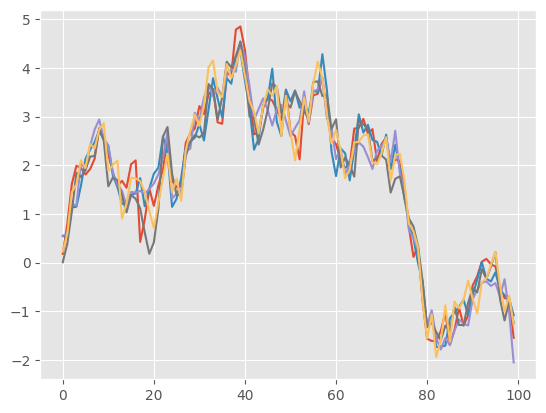

In [31]:
trajectories = alg.hist.backward_sampling_ON2(5)
plt.plot(trajectories)

backward_sampling_ON2は100個のarrayのリスト：trajectories[t][m]はt時点の軌跡mを表す。

particlesではいくつかのFFBSアルゴリズムを実装している。backward_sampling_ON2は最も基本的なもので、N個の軌跡を作成しようとすると$O(N^2)$の計算量となる（ここでNは初期粒子数）。

他にもDau & Chopin (2023)に基づく、より高速で推奨されるbackward_sampling_mcmcがある（MCMCに頼っている）。これは高速であり、他の棄却サンプリングベースのスキームに対して、確定的な実行時間$O(N)$を持つ。

two-filter smoothingも利用可能（詳細は本で勉強予定）

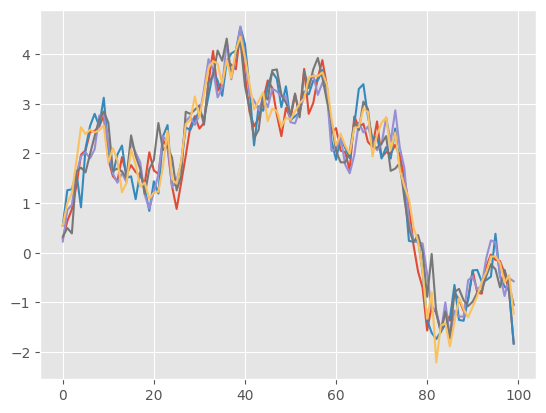

In [34]:
trajectories = alg.hist.backward_sampling_mcmc(5)
plt.plot(trajectories)